In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from scipy import stats
from scipy.stats import norm, mannwhitneyu
from tqdm.auto import tqdm

1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.

Подгрузим и посмотрим данные, разделитель - ";"

In [3]:
reg_data = pd.read_csv('../shared/problem1-reg_data.csv', sep = ';')
auth_data= pd.read_csv('../shared/problem1-auth_data.csv', sep = ';')

Быстро глянем на датасеты

In [4]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [5]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


Проверим, что количество уникальных айди одинаково в обоих датасетах, мало ли.

In [6]:
reg_data.uid.nunique()

1000000

In [7]:
auth_data.uid.nunique()

1000000

Проверим на пустые ячейки.

In [8]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [9]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [10]:
# Функция для подсчета ретеншена. Проведем когортный анализ, будет достаточно репрезентативно, к тому же можно задать
# любой необходимый отрезок времени.

def retention(reg, auth, first_date=None, last_date=None):
    
    # Сконвертируем дату в человеческий вид.

    reg['reg_ts'] = pd.to_datetime(reg['reg_ts'], unit='s').dt.date
    auth['auth_ts'] = pd.to_datetime(auth['auth_ts'], unit='s').dt.date

    # Зададим период, за которй хотим провести анализ.

    reg = reg.query('reg_ts >= @first_date')
    auth = auth.query('auth_ts <= @last_date') 
    
    # Объединим таблицы и добавим столбец для дельты между датой регистрации и датой входа.

    general = reg.merge(auth, on='uid')
    general['delta'] = (general.auth_ts - general.reg_ts).dt.days
    
    # Соберем таблицу, чтобы посмотреть количество новых пользователей после регистрации с различными дельтами
    # и датой регистрации, а затем перевернем все это дело для получения последующего ретеншена.

    general_cohort = general.groupby(['reg_ts','delta'], as_index=False)\
                    .agg({'uid':'nunique'})
    general_cohort = general_cohort.pivot(index='reg_ts', columns='delta', values='uid')
    retention_table = general_cohort.div(general_cohort[0], axis=0)
    
    # Немного преобразим получившуюся таблицу для большей репрезентативности. Идеальный варинат для хитмапа.

    plt.figure(figsize=(20, 8))
    plt.title('Retention table')
    sns.heatmap(data=retention_table, annot=True, vmin=0, vmax=0.12, fmt='1.0%', cmap='rocket_r')
    plt.show()

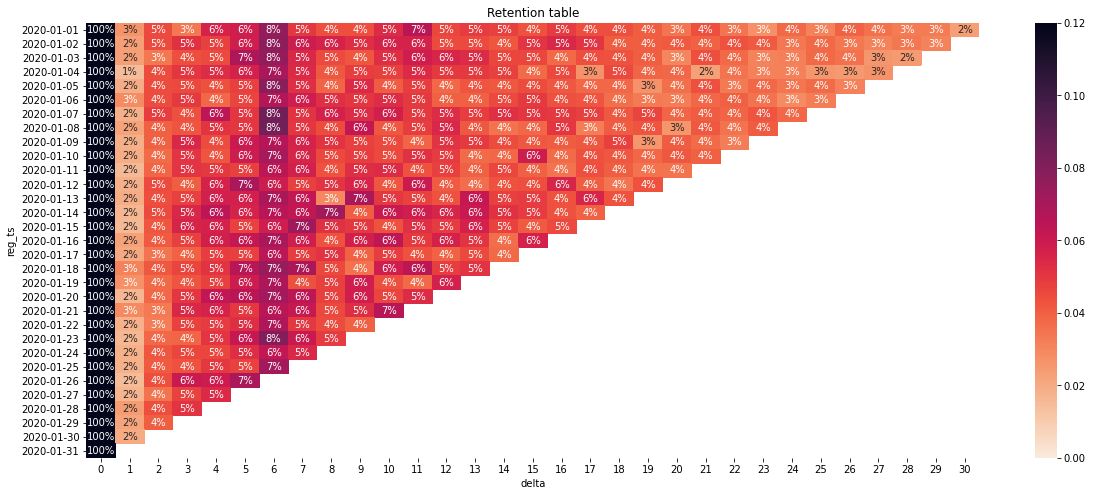

In [11]:
retention(reg_data, auth_data, first_date = datetime.date(2020, 1, 1), last_date = datetime.date(2020, 1, 31))

Выглядит неплохо, можно поиграться с датами и подобрать больший или меньший диапазон 
для окраса (скорее меньший, т.е. меньше 0.12) для большей репрезентативности, 
однако большие диапазоны дат (3 и более месяцев) грузить нежелательно, ибо карта становится нечитабельна.

2. Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного 
решения и как?

Подгрузим и посмотрим данные, разделитель - ";"

In [14]:
df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/12gk_ATEeBZm4A', sep = ';')

Посмотрим на датафрейм.

In [15]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


Глянем общие данные о столбце revenue у каждой группы, при этом смотреть пока будем только тех, кто хоть что-нибудь 
потратил.

In [16]:
df.query('revenue > 0 and testgroup == "a"').describe()

,user_id,revenue
count,1928.000000,1928.000000
mean,200152.677905,2663.998444
std,116596.504905,9049.039763
min,73.000000,200.000000
25%,99323.000000,257.000000
50%,199854.500000,311.000000
75%,299664.250000,361.000000
max,404768.000000,37433.000000


In [17]:
df.query('revenue > 0 and testgroup == "b"').describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,205834.548476,3003.658172
std,116400.045485,572.619709
min,161.000000,2000.000000
25%,106815.000000,2513.000000
50%,206651.000000,3022.000000
75%,304907.000000,3478.000000
max,404526.000000,4000.000000


a - контрольная группа, b - тестовая. У контрольной видно большой выброс на максимуме, у тестовой все выглядит нормально,
средняя и медиана примерно равны, должно быть нормальное распределение, надо глянуть на графиках. Для простоты разделим
общий датасет на два.

In [18]:
df_a = df.query('testgroup == "a"')
df_b = df.query('testgroup == "b"')

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


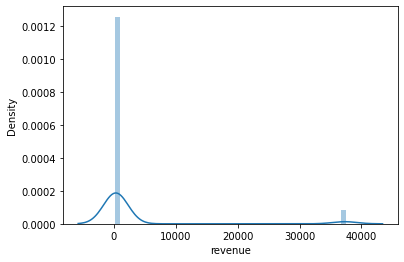

In [19]:
sns.distplot(df_a.query('revenue > 0').revenue)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


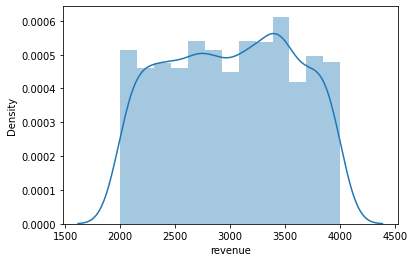

In [20]:
sns.distplot(df_b.query('revenue > 0').revenue)

Все верно, группа а имеет ярко выраженные выбросы, группа b - похоже на нормальное распределение.
Проверим, так ли это используя тест Шапиро.

In [21]:
stats.shapiro(df_b.query('revenue > 0').revenue)

ShapiroResult(statistic=0.9583123922348022, pvalue=2.491345674771425e-22)

pvalue < 0.05, следовательно распределение не явлеяется нормальным.

Теперь давайте разберемся с группой а. Сначала попробуем избавиться от выбросов, а затем проверим на нормальность.

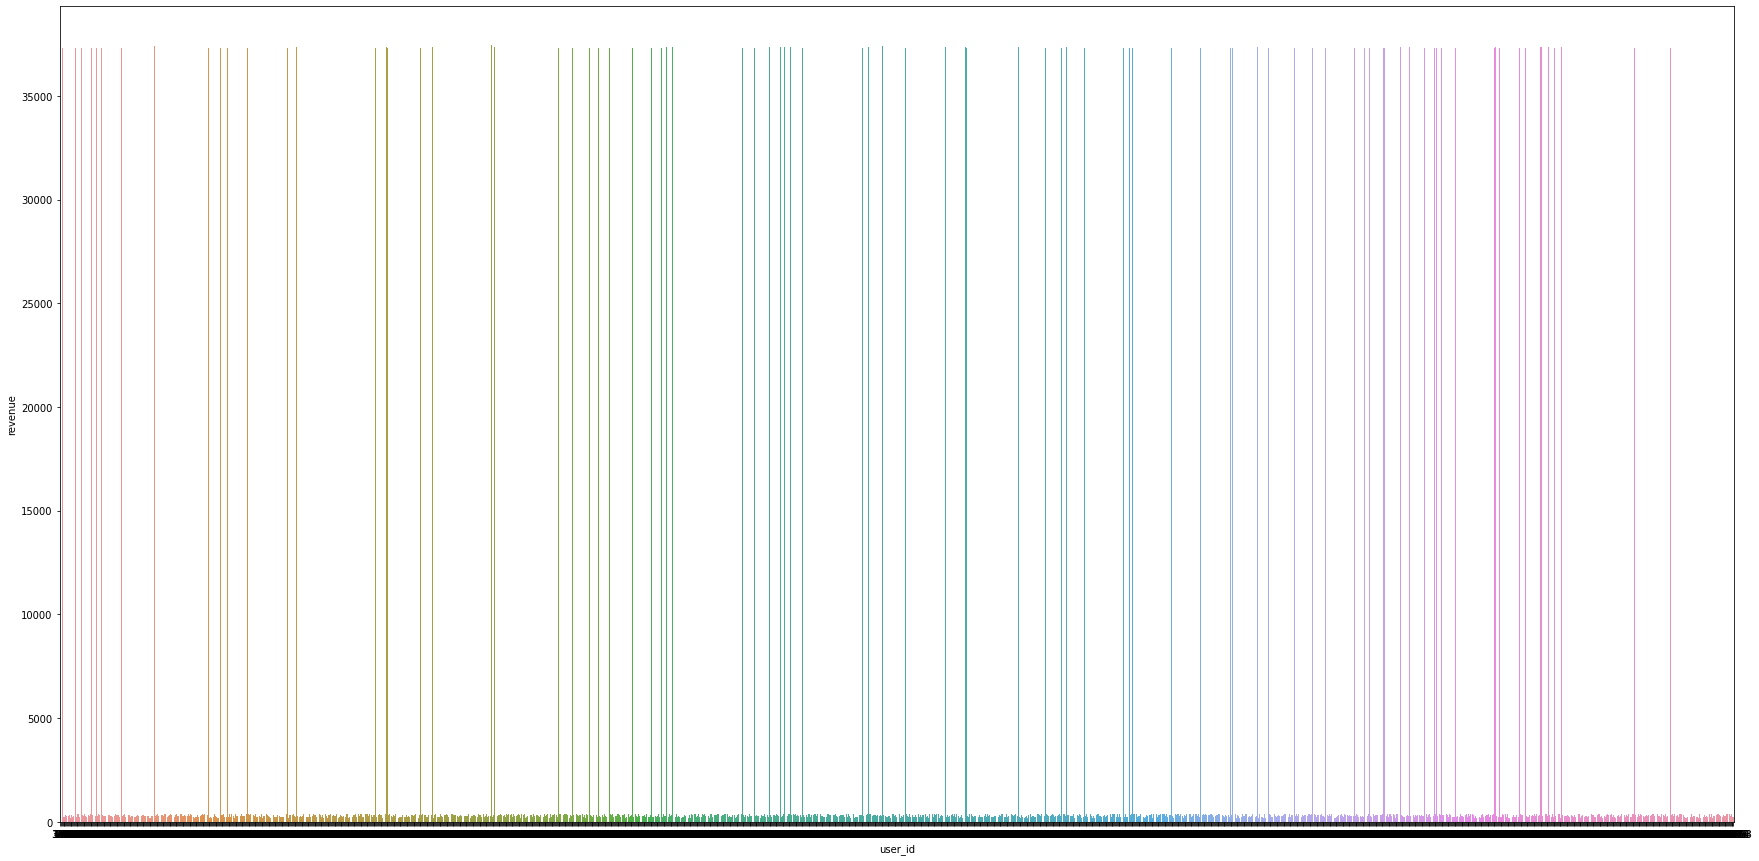

In [23]:
plt.figure(figsize=(30, 15))
sns.barplot(data=df_a.query('revenue > 0'), x="user_id", y="revenue")

График не очень четкий, но важнее просто увидеть наличие выбросов, и то, что они все находятся выше значения 5000,
хотя стандартные значения не доходят и до 1000. Исключим аномальные значения из датафрейма.

In [24]:
df_a.query('revenue > 0 and revenue < 5000').describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,199923.686981,302.458172
std,116615.234772,57.914246
min,73.000000,200.000000
25%,98963.000000,254.000000
50%,199268.000000,305.000000
75%,298918.000000,352.000000
max,404768.000000,400.000000


Оказалось, что у нас есть 123 (1928-1805) выброса, средняя и медиана почти одинаковы, глянем график и проверим
с помощью Шапиро.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


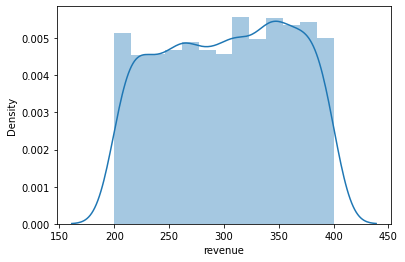

In [25]:
sns.distplot(df_a.query('revenue > 0 and revenue < 5000').revenue)

In [26]:
stats.shapiro(df_a.query('revenue > 0 and revenue < 5000').revenue)

ShapiroResult(statistic=0.9546283483505249, pvalue=3.004845972000649e-23)

Шапиро указывает на то, что распределение не является нормальным. Посмотрим, что скажет бутстрап через медиану. 
Использовать среднюю было бы неверно при наличии весомых аномалий.

Считаем только для пользователей, которые что-либо потратили.

In [28]:
data_column_1 = df_a.query('revenue > 0').revenue
data_column_2 = df_b.query('revenue > 0').revenue

In [29]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

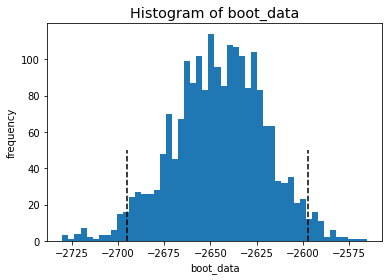

In [30]:
booted_data = get_bootstrap(data_column_1, data_column_2, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [31]:
booted_data["p_value"]

0.0

In [32]:
booted_data["ci"]

,0
0.025,-2695.0000
0.975,-2596.9875


Доверительный интервал меньше нуля, нулевую гипотезу об отсутствии различий в данных отклоняем.

In [34]:
mannwhitneyu(x=df_a.query('revenue > 0').revenue, y=df_b.query('revenue > 0').revenue, alternative = 'two-sided')

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

Тест Манна-Уитни с p-value < 0.05 указывает на то, что медианы двух выборок существенно отличаются от друг друга.
Давайте заодно еще раз проверим, как сильно отличаются ARPU и ARPPU у групп.

In [42]:
arpu_a = df_a.revenue.sum()/df_a.shape[0]

In [41]:
arpu_b = df_b.revenue.sum()/df_b.shape[0]

In [48]:
round(((arpu_b / arpu_a) - 1) * 100, 2)

5.26

In [49]:
arppu_a = df_a.query("revenue > 0").revenue.sum() / df_a.query("revenue > 0").shape[0]

In [50]:
arppu_b = df_b.query("revenue > 0").revenue.sum() / df_b.query("revenue > 0").shape[0]

In [51]:
round(((arppu_b / arppu_a) - 1) * 100, 2)

12.75

Получается, что в тестовой ARPPU тоже больше, но уже на целых 12 процентов.

Некоторые выводы.
Если мы берем за расчет, что сильные выбросы - это крайне лояльные покупатели, а не ошибка выборки, то считаю,
что можно использовать предложение тестовой выборки, так как те же ARPU и ARPPU выше (хоть и пользователей
количественно стало меньше, но выбросы, все-таки, стоит проверить и убедиться, что это действительно наши самые 
крутые пользователи, а не ошибка данных. Тесты Манна-Уитни и Бутстрап показали статистически разницу для платящих 
пользователей.

3. С помощью каких метрик можно оценить результаты последнего прошедшего события? Предположим, в другом событии мы
усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на 
несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Метрики.
Retention - обыкновенное удержание по дням.
Daily Active Users (DAU), так как ивент идет, скорее всего, непродолжительное время, то именно эта метрика подойдет 
лучше всего, а не тот же MAU.
Средняя продолжительность сессии с учетом количества выполненных заданий ивента за день, при этом стоит учесть тех
пользователей, что не стали просто гриндить ивент, а купили желаемое напрямую.
ARPPU - при, опять-таки, наличии возможность купить какую-то награду не выполняя задания. 

Усложнение.
Метрики, в целом, останутся преждними, игра то не меняется, но появляются аспекты.
Важно отслеживать отток пользователей после неудач, поскольку именно он будет отображать основную реакцию 
пользоватлей на внесение подобной механики и насколько это влияет на последующие заходы пользователя в игру. Т.е. 
необходимо отследивать, чтобы он не просто ушел из-за неудачного уровня, но и не забросил игру на долгое время или 
насовсем.
Проблемные уровни и количество попыток их пройти, будет видно где люди страдают больше и откорректировать при
возможности.